In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np

In [3]:
sys.path.append("../../")
import logging
from microfit.analysis import MultibandAnalysis
from microfit.fileio import from_json, to_json
from microfit.parameters import Parameter, ParameterSet

In [4]:
config_file = "../../config_files/old_model_ana_with_detvars.toml"
output_dir = "../../old_model_ana_output_with_3a/"

analysis = MultibandAnalysis.from_toml(
    config_file,
    logging_level=logging.DEBUG,
    overwrite_cached_df=False,
    overwrite_cached_df_detvars=False,
    output_dir=output_dir,
)
analysis.output_dir = None

Output dir from config overridden to: ../../old_model_ana_output_with_3a/
Loading run 3_crt


Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5
Loading devar histograms from file: /nashome/a/atrettin/PELEE/old_model_ana_output_with_3a/detvar_cache/run_3_crt4b4c4d5_NUMUCRTNP0PI_NUMUCRT0P0PI_NUMUCRT_bnb.json
Making plots for mc
Making plots for nue
Making plots for nc_pi0
Making plots for mc
Making plots for nue
Making plots for nc_pi0
Making plots for mc
Making plots for nue
Making plots for nc_pi0
Loading run 3_crt
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5
Loading devar histograms from file: /nashome/a/atrettin/PELEE/old_model_ana_output_with_3a/detvar_cache/run_3_crt4b4c4d5_TWOSHR_bnb.json
Making plots for mc
Making plots for nue
Making plots for nc_pi0
Loading run 1
Loading run 2
Loading run 3_nocrt
Loading run 3_crt
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5
Loading devar histograms from file: /nashome/a/atrettin/PELEE/old_model_ana_output_with_3a/detvar_cache/run_123_nocrt3_crt4b4c4d5_NPBDT_ZPBDT_ZPBDT_NOCRT_bnb_(mcf_pass_ncpi0_eqeq

In [29]:
signal_channel = "NPBDT"

analysis.signal_channels = [signal_channel]

(<Figure size 600x500 with 1 Axes>,
 array([[<AxesSubplot:xlabel='Reconstructed Energy (GeV)', ylabel='Events'>]],
       dtype=object))

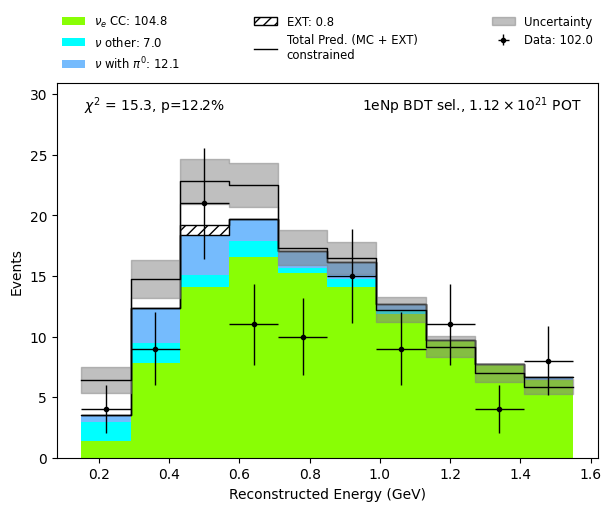

In [30]:
analysis.plot_signals(
    add_precomputed_detsys=True,
    show_chi_square=True
)

In [31]:
h0_params = ParameterSet([Parameter("signal_strength", 0.0)])
h1_params = ParameterSet([Parameter("signal_strength", 1.0)])

analysis.set_parameters(h0_params)
sig_hist_h0 = analysis.get_mc_hist(
    add_precomputed_detsys=True,
    use_sideband=True,
)[signal_channel]

analysis.set_parameters(h1_params)
sig_hist_h1 = analysis.get_mc_hist(
    add_precomputed_detsys=True,
    use_sideband=True,
)[signal_channel]

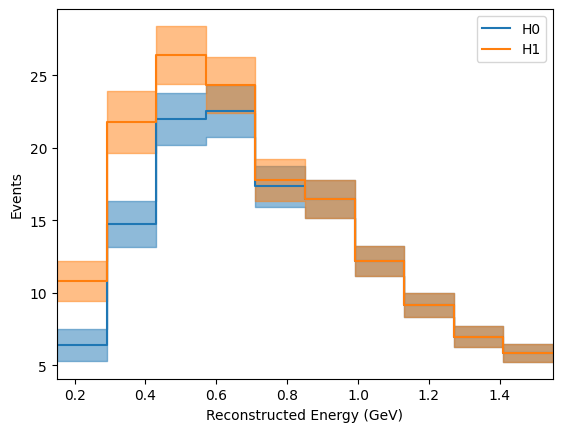

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sig_hist_h0.draw(ax=ax, label="H0")
sig_hist_h1.draw(ax=ax, label="H1")
ax.legend()

In [33]:
print(sig_hist_h0.sum_std())

7.415944040279528


In [37]:
from microfit.histogram import Histogram

def extract_bin_range(histogram, bin_range):
    """Extract a range of bins from a given histogram.
    
    The returned Histogram has all of the same properties as the original,
    but with a reduced number of bins. The covariance matrix is also 
    updated accordingly.
    """
    new_binning = histogram.binning.copy()
    new_binning.bin_edges = new_binning.bin_edges[bin_range[0]:bin_range[1] + 2]
    new_covariance_matrix = histogram.covariance_matrix[
        bin_range[0]:bin_range[1]+1, bin_range[0]:bin_range[1]+1
    ]
    new_histogram = Histogram.empty_like(histogram)
    new_histogram.binning = new_binning
    new_histogram.covariance_matrix = new_covariance_matrix
    new_histogram.bin_counts = histogram.bin_counts[bin_range[0]:bin_range[1]+1]
    return new_histogram
    

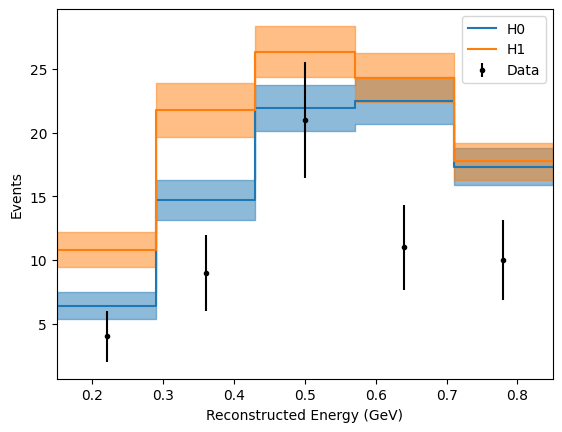

In [42]:
sig_hist_h0_sigrange = extract_bin_range(sig_hist_h0, [0, 4])
sig_hist_h1_sigrange = extract_bin_range(sig_hist_h1, [0, 4])
data_hist = analysis.get_data_hist()[signal_channel]
data_hist_sigrange = extract_bin_range(data_hist, [0, 4])

fig, ax = plt.subplots()
sig_hist_h0_sigrange.draw(ax=ax, label="H0")
sig_hist_h1_sigrange.draw(ax=ax, label="H1")
data_hist_sigrange.draw(ax=ax, label="Data", color="black", as_errorbars=True)
ax.legend()

In [51]:
from microfit.statistics import chi_square

chi2_h0 = chi_square(
    data_hist_sigrange.bin_counts,
    sig_hist_h0_sigrange.bin_counts,
    sig_hist_h0_sigrange.covariance_matrix
)
print(chi2_h0)

chi2_h1 = chi_square(
    data_hist_sigrange.bin_counts,
    sig_hist_h1_sigrange.bin_counts,
    sig_hist_h1_sigrange.covariance_matrix
)
print(chi2_h1)

12.138425888635663
23.482861808429778


In [98]:
from tqdm import tqdm
# Produce a chi-square distribution from pseudo data trials to get the p-value
def get_chi2_dist(expectation_histogram, n_trials=1000):
    rng = np.random.default_rng(0)
    chi2_values = []
    for _ in tqdm(range(n_trials)):
        pseudo_data = expectation_histogram.fluctuate(rng=rng).fluctuate_poisson(rng=rng)
        # Finally, calculate the chi-square value
        chi2 = chi_square(
            pseudo_data.bin_counts,
            expectation_histogram.bin_counts,
            expectation_histogram.covariance_matrix
        )
        chi2_values.append(chi2)
    chi2_values = np.array(chi2_values)
    return chi2_values

In [99]:
# Pack the above into a function that takes as argument the analysis and the channel
# and then produces the dictionary with the data

def get_pelee_data(analysis, channel, name):
    analysis.signal_channels = [channel]
    h0_params = ParameterSet([Parameter("signal_strength", 0.0)])
    h1_params = ParameterSet([Parameter("signal_strength", 1.0)])

    analysis.set_parameters(h0_params)
    sig_hist_h0 = analysis.generate_multiband_histogram(
        include_multisim_errors=True,
        add_precomputed_detsys=True,
        use_sideband=True,
    )[channel]

    analysis.set_parameters(h1_params)
    sig_hist_h1 = analysis.generate_multiband_histogram(
        include_multisim_errors=True,
        add_precomputed_detsys=True,
        use_sideband=True,
    )[channel]

    sig_hist_h0_sigrange = extract_bin_range(sig_hist_h0, [0, 4])
    sig_hist_h1_sigrange = extract_bin_range(sig_hist_h1, [0, 4])
    data_hist = analysis.get_data_hist()[channel]
    data_hist_sigrange = extract_bin_range(data_hist, [0, 4])

    # The chi-square and p-values are supposed to use the entire binning range.
    chi2_h0 = chi_square(
        data_hist.bin_counts,
        sig_hist_h0.bin_counts,
        sig_hist_h0.covariance_matrix
    )

    chi2_h1 = chi_square(
        data_hist.bin_counts,
        sig_hist_h1.bin_counts,
        sig_hist_h1.covariance_matrix
    )

    chi2_h0_distribution = get_chi2_dist(sig_hist_h0, n_trials=10000)

    p_value_h0 = np.sum(chi2_h0_distribution > chi2_h0) / len(chi2_h0_distribution)

    pelee_data = { "name": name,
        "e_sig": [(150,850)], #mev
        "observed": data_hist_sigrange.sum(),
        "expected_x0": sig_hist_h0_sigrange.sum(),
        "expected_x0_err_sys": sig_hist_h0_sigrange.sum_std(),
        "expected_x1": sig_hist_h1_sigrange.sum(),
        "expected_x1_err_sys": sig_hist_h1_sigrange.sum_std(),
        #from PeLEE PRD
        "chi2_x0": chi2_h0,
        "chi2_x1": chi2_h1,
        "chi2_df": sig_hist_h0.binning.n_bins,
        #pvalues for constrained H0/H1
        "p_x0": p_value_h0,
        "p_x1": None,
    }

    return pelee_data

In [100]:
pelee_data_np = get_pelee_data(analysis, "NPBDT", "$1eNp0\\pi$")

100%|██████████| 10000/10000 [00:09<00:00, 1081.69it/s]


In [101]:
print(pelee_data_np)

{'name': '$1eNp0\\pi$', 'e_sig': [(150, 850)], 'observed': 55.0, 'expected_x0': 83.79708436475646, 'expected_x0_err_sys': 5.094631168366703, 'expected_x1': 101.89356554337985, 'expected_x1_err_sys': 6.114660634680027, 'chi2_x0': 15.274168473591722, 'chi2_x1': 26.714877897667673, 'chi2_df': 10, 'p_x0': 0.1768, 'p_x1': None}


In [102]:
pelee_data_zp = get_pelee_data(analysis, "ZPBDT", "$1e0p0\\pi$")
print(pelee_data_zp)

100%|██████████| 10000/10000 [00:08<00:00, 1156.94it/s]

{'name': '$1e0p0\\pi$', 'e_sig': [(150, 850)], 'observed': 36.0, 'expected_x0': 38.30732518931956, 'expected_x0_err_sys': 3.378090940936914, 'expected_x1': 46.07747096225511, 'expected_x1_err_sys': 3.656393854023885, 'chi2_x0': 10.08009426192946, 'chi2_x1': 9.678964550467258, 'chi2_df': 10, 'p_x0': 0.5471, 'p_x1': None}


In [105]:
# A function that combines channels. 
# Expectation values are just summed, errors summed in quadrature. For the p-values,
# use the analysis functions to get the chi-square.

def get_pelee_data_multichannel(analysis, channels, names):
    analysis.signal_channels = channels
    h0_params = ParameterSet([Parameter("signal_strength", 0.0)])
    h1_params = ParameterSet([Parameter("signal_strength", 1.0)])

    analysis.set_parameters(h0_params)
    sig_hist_h0 = analysis.generate_multiband_histogram(
        include_multisim_errors=True,
        add_precomputed_detsys=True,
        use_sideband=True,
    )

    analysis.set_parameters(h1_params)
    sig_hist_h1 = analysis.generate_multiband_histogram(
        include_multisim_errors=True,
        add_precomputed_detsys=True,
        use_sideband=True,
    )

    data_hist = analysis.get_data_hist()
    signal_expectation = 0
    signal_variance = 0
    signal_observed_sum = 0
    for channel in channels:
        sig_hist_h0_channel = sig_hist_h0[channel]
        sig_hist_h1_channel = sig_hist_h1[channel]
        sig_hist_h0_sigrange = extract_bin_range(sig_hist_h0_channel, [0, 4])
        sig_hist_h1_sigrange = extract_bin_range(sig_hist_h1_channel, [0, 4])
        data_hist_sigrange = extract_bin_range(data_hist[channel], [0, 4])

        signal_expectation += sig_hist_h0_sigrange.sum()
        signal_variance += sig_hist_h0_sigrange.sum_std()**2
        signal_observed_sum += data_hist_sigrange.sum()
    signal_err = np.sqrt(signal_variance)

    # The chi-square and p-values are supposed to use the entire binning range.
    # The multi-channel histograms automatically unroll themselves.
    chi2_h0 = chi_square(
        data_hist.bin_counts,
        sig_hist_h0.bin_counts,
        sig_hist_h0.covariance_matrix
    )

    chi2_h1 = chi_square(
        data_hist.bin_counts,
        sig_hist_h1.bin_counts,
        sig_hist_h1.covariance_matrix
    )

    chi2_h0_distribution = get_chi2_dist(sig_hist_h0, n_trials=10000)
    plt.figure()
    plt.hist(chi2_h0_distribution, bins=100)

    p_value_h0 = np.sum(chi2_h0_distribution > chi2_h0) / len(chi2_h0_distribution)

    pelee_data = { "name": "+".join(names),
        "e_sig": [(150,850)], #mev
        "observed": signal_observed_sum,
        "expected_x0": signal_expectation,
        "expected_x0_err_sys": signal_err,
        "expected_x1": signal_expectation,
        "expected_x1_err_sys": signal_err,
        #from PeLEE PRD
        "chi2_x0": chi2_h0,
        "chi2_x1": chi2_h1,
        "chi2_df": sig_hist_h0.binning.n_bins,
        #pvalues for constrained H0/H1
        "p_x0": p_value_h0,
        "p_x1": None,
    }
    return pelee_data

100%|██████████| 10000/10000 [00:15<00:00, 651.51it/s]


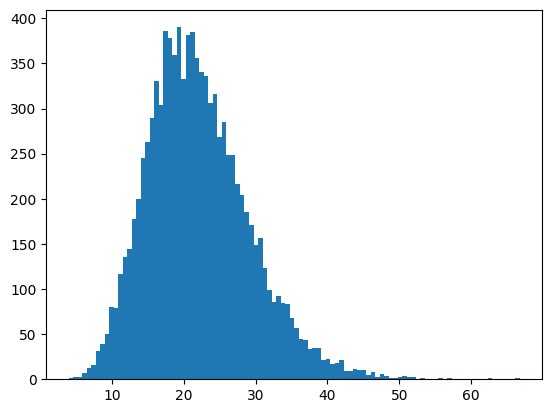

In [106]:
combined_pelee_data = get_pelee_data_multichannel(analysis, ["NPBDT", "ZPBDT"], ["$1eNp0\\pi$", "$1e0p0\\pi$"])

In [107]:
print(combined_pelee_data)

{'name': '$1eNp0\\pi$+$1e0p0\\pi$', 'e_sig': [(150, 850)], 'observed': 91.0, 'expected_x0': 122.10440955407603, 'expected_x0_err_sys': 6.1128360968484605, 'expected_x1': 122.10440955407603, 'expected_x1_err_sys': 6.1128360968484605, 'chi2_x0': 25.295803083295993, 'chi2_x1': 35.70113393196634, 'chi2_df': 20, 'p_x0': 0.2944, 'p_x1': None}


In [108]:
analysis.signal_channels = ["NPBDT"]
two_hypo_result_npbdt = analysis.two_hypothesis_test(
    h0_params=ParameterSet([Parameter("signal_strength", 0.0)]),
    h1_params=ParameterSet([Parameter("signal_strength", 1.0)]),
    sensitivity_only=True,
    n_trials=10000,
)

Generating H0 histogram
Generating H1 histogram


Generating pseudo-experiments: 100%|██████████| 10000/10000 [00:23<00:00, 433.45it/s]


In [109]:
analysis.signal_channels = ["ZPBDT"]
two_hypo_result_zpbdt = analysis.two_hypothesis_test(
    h0_params=ParameterSet([Parameter("signal_strength", 0.0)]),
    h1_params=ParameterSet([Parameter("signal_strength", 1.0)]),
    sensitivity_only=True,
    n_trials=10000,
)

Generating H0 histogram
Generating H1 histogram


Generating pseudo-experiments: 100%|██████████| 10000/10000 [00:20<00:00, 498.16it/s]


In [110]:
def plot_two_hypo_result(two_hypo_results, plot_path, title):
    # read results from file
    minimum = np.min(two_hypo_results["samples_h0"])
    minimum = min(minimum, np.min(two_hypo_results["samples_h1"]))
    maximum = np.max(two_hypo_results["samples_h0"])
    maximum = max(maximum, np.max(two_hypo_results["samples_h1"]))

    n_trials = len(two_hypo_results["samples_h0"])
    bin_edges = np.linspace(minimum, maximum, int(np.sqrt(n_trials)))

    fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
    ax.hist(
        two_hypo_results["samples_h0"], bins=bin_edges, histtype="step", density=False, label="H0"
    )
    ax.hist(
        two_hypo_results["samples_h1"], bins=bin_edges, histtype="step", density=False, label="H1"
    )
    ax.axvline(
        x=two_hypo_results["ts_median_h1"],
        color="k",
        linestyle="--",
        label=f"Median H1\np-val: {two_hypo_results['median_pval']*100:0.3f}%",
    )
    ax.legend()
    ax.set_xlabel(r"$\Delta \chi^2$")
    ax.set_ylabel("Samples")
    ax.set_title(title)
    # fig.savefig(plot_path)

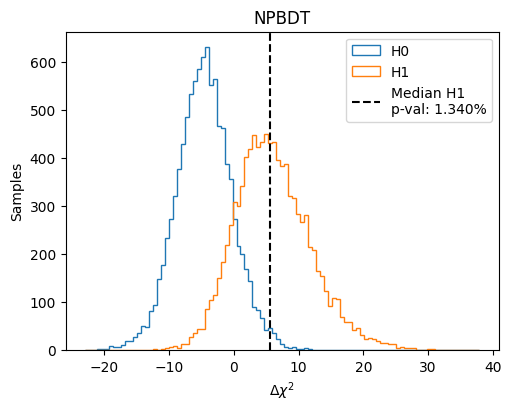

In [111]:
plot_two_hypo_result(two_hypo_result_npbdt, "npbdt_two_hypo.png", "NPBDT")